In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from sklearn.metrics import classification_report

# GPU 메모리 점진적 할당 (OOM 방지)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 설정 완료")
    except RuntimeError as e:
        print(e)

✅ GPU 설정 완료


In [2]:
# 기존 all.csv 파일 경로 (사용자 환경에 맞게 수정 필요하면 수정하세요)
csv_path = "all.csv" 

if os.path.exists(csv_path):
    print(f"📂 {csv_path} 파일을 읽는 중...")
    df = pd.read_csv(csv_path)
    
    # 차종(vehicle_type)을 숫자로 변환
    # (검증 데이터와 순서 통일: Big=0, Middle=1, Little=2)
    type_mapping = {"big": 0, "middle": 1, "little": 2}
    
    # 공백 제거 후 매핑
    df['type_code'] = df['vehicle_type'].str.strip().map(type_mapping)
    
    # 결측치 확인
    if df['type_code'].isnull().any():
        print("⚠️ 주의: 알 수 없는 차종이 포함되어 있습니다.")
        print(df[df['type_code'].isnull()])
    else:
        # uint8로 변환하여 저장
        type_train = df['type_code'].values.astype(np.uint8)
        np.save("type_train.npy", type_train)
        
        print("\n✅ 학습용 차종 라벨 생성 완료: type_train.npy")
        print(f" - 총 데이터 개수: {len(type_train)}")
        print(f" - 차종별 분포:")
        print(f"   🚛 Big (0):    {np.sum(type_train==0)}장")
        print(f"   🚗 Middle (1): {np.sum(type_train==1)}장")
        print(f"   🚙 Little (2): {np.sum(type_train==2)}장 (가장 취약했던 차종)")
        
else:
    print(f"❌ {csv_path} 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

📂 all.csv 파일을 읽는 중...

✅ 학습용 차종 라벨 생성 완료: type_train.npy
 - 총 데이터 개수: 328211
 - 차종별 분포:
   🚛 Big (0):    75583장
   🚗 Middle (1): 103359장
   🚙 Little (2): 149269장 (가장 취약했던 차종)


In [9]:
# ✅ 1. 데이터 정합성 검사 및 인덱스 재생성 (수정됨)
def create_valid_dataset(csv_path, img_folder, target_type):
    print("🔄 데이터 정합성 검사 중... (누락된 파일 제외 및 차종 필터링)")
    
    # 1. CSV 로드 (원본 정보)
    df = pd.read_csv(csv_path)
    
    # 2. 차종 필터링 (Big:0, Middle:1, Little:2)
    # 문자열 공백 제거 및 소문자 변환 후 매핑
    type_mapping = {"big": 0, "middle": 1, "little": 2}
    df['type_code'] = df['vehicle_type'].str.strip().str.lower().map(type_mapping)
    
    # 원하는 차종만 선택
    target_df = df[df['type_code'] == target_type].copy()
    
    valid_paths = []
    valid_labels = []
    
    # 3. 실제 파일 존재 여부 확인 (가장 중요!)
    # df.index는 원본 CSV의 인덱스(=파일 번호)를 가지고 있음
    for original_idx, row in tqdm(target_df.iterrows(), total=len(target_df)):
        file_name = f"img_{original_idx:05d}.npy"
        file_path = os.path.join(img_folder, file_name)
        
        # 파일이 실제로 있을 때만 리스트에 추가
        if os.path.exists(file_path):
            valid_paths.append(file_path)
            # 라벨: 불법=1, 정상=0
            label = 1 if row['label'] == '불법' else 0
            valid_labels.append(label)
            
    print(f"✅ 정제 완료: {len(valid_paths)}장 선택됨 (Target Type: {target_type})")
    return np.array(valid_paths), np.array(valid_labels, dtype=np.float32)

# ✅ 2. 안전한 제너레이터 (경로를 직접 받음)
class SafeGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.file_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        X = []
        for i in batch_indices:
            X.append(np.load(self.file_paths[i]))
            
        return np.array(X, dtype=np.float32), self.labels[batch_indices]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ✅ 3. 설정 및 데이터 로딩
TRAIN_CSV_PATH = "all.csv"
TRAIN_IMG_DIR = "full_npy_images"

# 검증 데이터 (기존 방식 유지해도 무방하지만 안전하게 로딩)
VAL_IMG_DIR = r"D:\workspace\full_val_npy"
VAL_LABEL_PATH = os.path.join(VAL_IMG_DIR, "y_full.npy")
VAL_TYPE_PATH = os.path.join(VAL_IMG_DIR, "type_full.npy")

# --- 학습 데이터 준비 (Little = 2) ---
# 여기서 시간이 조금 걸리지만, 데이터 꼬임을 완벽하게 방지합니다.
X_train_paths, y_train = create_valid_dataset(TRAIN_CSV_PATH, TRAIN_IMG_DIR, target_type=2)

# --- 검증 데이터 준비 (Little = 2) ---
# 검증 데이터는 npy가 완벽하다고 가정하고 기존 방식 사용 (속도 위해)
val_types = np.load(VAL_TYPE_PATH)
val_indices = np.where(val_types == 2)[0] # Little만 선택
val_paths = [os.path.join(VAL_IMG_DIR, f"img_{i:05d}.npy") for i in val_indices]
val_labels = np.load(VAL_LABEL_PATH)[val_indices]

# ✅ 4. 제너레이터 생성 (Batch 64, Mixed Precision 적용)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

BATCH_SIZE = 32
train_gen = SafeGenerator(X_train_paths, y_train, BATCH_SIZE, shuffle=True)
val_gen = SafeGenerator(np.array(val_paths), val_labels, BATCH_SIZE, shuffle=False)

# ✅ 5. 모델 정의 및 학습
def create_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True 
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid', dtype='float32') # Mixed Precision 출력은 float32로
    ])
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

checkpoint_path = "best_weights_little.h5"
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    
    ModelCheckpoint(
        checkpoint_path, 
        monitor='val_accuracy', 
        save_best_only=True, 
        save_weights_only=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

print(f"\n🔥 [Little 전문가 모델] 학습 시작 (데이터 정렬 완료!)")
history = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=15, 
    callbacks=callbacks,
    workers=8,
    use_multiprocessing=False,
    max_queue_size=20
)

🔄 데이터 정합성 검사 중... (누락된 파일 제외 및 차종 필터링)


100%|████████████████████████████████████████████████████████████████████████| 149269/149269 [00:22<00:00, 6723.04it/s]


✅ 정제 완료: 149269장 선택됨 (Target Type: 2)

🔥 [Little 전문가 모델] 학습 시작 (데이터 정렬 완료!)
Epoch 1/15
4665/4665 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9222
Epoch 1: val_accuracy improved from -inf to 0.47039, saving model to best_weights_little.h5
4665/4665 [==============================] - 679s 143ms/step - loss: 0.1965 - accuracy: 0.9222 - val_loss: 0.9704 - val_accuracy: 0.4704 - lr: 1.0000e-04
Epoch 2/15
4665/4665 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9470
Epoch 2: val_accuracy did not improve from 0.47039
4665/4665 [==============================] - 662s 142ms/step - loss: 0.1327 - accuracy: 0.9470 - val_loss: 0.7607 - val_accuracy: 0.4537 - lr: 1.0000e-04
Epoch 3/15
4665/4665 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9630
Epoch 3: val_accuracy improved from 0.47039 to 0.53904, saving model to best_weights_little.h5
4665/4665 [==============================] - 665s 143ms/step - loss: 0.0921 - accura

KeyboardInterrupt: 

In [10]:
# 🔥 가장 똑똑해진 현재 모델을 수동으로 저장 (필수!)
model.save_weights("final_weights_little_manual.h5")
print("✅ 학습된 가중치를 안전하게 저장했습니다: final_weights_little_manual.h5")

✅ 학습된 가중치를 안전하게 저장했습니다: final_weights_little_manual.h5


In [11]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

# ✅ 경로 확인 필수! (사용자님 원본 검증 데이터 폴더 경로)
BASE_VAL_DIR = r"D:\workspace\dataset\dataset\data\data\Validation\source"
NEW_VAL_DIR = r"D:\workspace\clean_val_npy" # 새로 저장될 곳
os.makedirs(NEW_VAL_DIR, exist_ok=True)

def create_clean_val_data(base_dir, save_dir):
    print(f"🔄 검증 데이터 재구축 시작...")
    
    # 데이터 리스트 수집
    data_infos = []
    # 소형차(little)만 우선적으로 확실하게 챙기기 위해 전체 다 변환
    for vt in ["big", "middle", "little"]:
        for cat in ["illegal", "normality"]:
            folder_path = os.path.join(base_dir, vt, cat)
            if not os.path.exists(folder_path): continue
                
            img_files = glob(os.path.join(folder_path, "*.jpg"))
            label = 1 if cat == "illegal" else 0
            type_code = {"big": 0, "middle": 1, "little": 2}[vt]
            
            for p in img_files:
                data_infos.append({"path": p, "label": label, "type": type_code})
    
    # 변환 및 저장
    labels, types = [], []
    print(f"📊 총 {len(data_infos)}장 변환 시작...")
    
    for i, info in enumerate(tqdm(data_infos)):
        try:
            img = cv2.imread(info['path'])
            if img is None: continue
            img = cv2.resize(img, (224, 224))
            
            # 파일명에 인덱스 부여하여 순서 고정
            np.save(os.path.join(save_dir, f"val_img_{i:05d}.npy"), img)
            labels.append(info['label'])
            types.append(info['type'])
        except: pass
            
    np.save(os.path.join(save_dir, "y_val_clean.npy"), np.array(labels))
    np.save(os.path.join(save_dir, "type_val_clean.npy"), np.array(types))
    print("✅ 검증 데이터 생성 완료!")

# 실행 (오래 걸리지 않습니다)
create_clean_val_data(BASE_VAL_DIR, NEW_VAL_DIR)

🔄 검증 데이터 재구축 시작...
📊 총 41025장 변환 시작...


100%|████████████████████████████████████████████████████████████████████████████| 41025/41025 [14:43<00:00, 46.45it/s]

✅ 검증 데이터 생성 완료!


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import Sequence
from sklearn.metrics import classification_report, accuracy_score

# ✅ 경로 설정
VAL_DIR = r"D:\workspace\clean_val_npy"
WEIGHTS_PATH = "final_weights_little_manual.h5"

print("📂 검증 데이터 준비 중...")
y_full = np.load(os.path.join(VAL_DIR, "y_val_clean.npy"))
type_full = np.load(os.path.join(VAL_DIR, "type_val_clean.npy"))

target_indices = np.where(type_full == 2)[0]
y_true = y_full[target_indices]
print(f"📊 소형차(Little) 검증 대상: {len(target_indices)}장")

# ✅ [수정된 제너레이터] 순정 BGR 사용 (색상반전 X)
class BGRGenerator(Sequence):
    def __init__(self, val_dir, indices, batch_size=32):
        self.val_dir = val_dir
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_inds = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X = []
        for i in batch_inds:
            file_path = os.path.join(self.val_dir, f"val_img_{i:05d}.npy")
            img = np.load(file_path)
            
            # ✅ 유일한 전처리: 0~1 스케일링만 적용!
            # (학습 때 cv2로 읽어서 그냥 저장했으므로 BGR 상태임. 검증도 똑같이 BGR로!)
            img = img.astype(np.float32) / 255.0
            
            X.append(img)
        return np.array(X)

test_gen = BGRGenerator(VAL_DIR, target_indices, batch_size=32)

# 모델 정의
def create_model():
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True 
    model = Sequential([
        base_model, GlobalAveragePooling2D(), Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid', dtype='float32')
    ])
    return model

model = create_model()

# 평가 실행
if os.path.exists(WEIGHTS_PATH):
    print(f"⚖️ 가중치 로드: {WEIGHTS_PATH}")
    model.load_weights(WEIGHTS_PATH)
    
    print("\n🔥 [최종] BGR 모드(학습 데이터와 동일) 평가 시작...")
    y_pred_prob = model.predict(test_gen, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # 개수 보정
    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

    print("\n" + "="*50)
    print(f"🏆 소형차(Little) BGR 평가 결과")
    print("="*50)
    acc = accuracy_score(y_true, y_pred)
    print(f"🎯 정확도: {acc:.4f}")
    
    if acc > 0.9:
        print("🎉 대성공입니다! BGR 문제가 맞았습니다!")
    else:
        print("🤔 아직도 낮다면 모델 학습 자체가 잘못되었을 가능성이 있습니다.")
        
    print(classification_report(y_true, y_pred, digits=4))
else:
    print("❌ 가중치 파일이 없습니다.")

📂 검증 데이터 준비 중...
📊 소형차(Little) 검증 대상: 18659장
⚖️ 가중치 로드: final_weights_little_manual.h5

🔥 [최종] BGR 모드(학습 데이터와 동일) 평가 시작...
584/584 [==============================] - 27s 45ms/step

🏆 소형차(Little) BGR 평가 결과
🎯 정확도: 0.5590
🤔 아직도 낮다면 모델 학습 자체가 잘못되었을 가능성이 있습니다.
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      8229
           1     0.5590    1.0000    0.7171     10430

    accuracy                         0.5590     18659
   macro avg     0.2795    0.5000    0.3586     18659
weighted avg     0.3125    0.5590    0.4008     18659



C:\Users\abc99\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abc99\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abc99\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🔬 데이터 및 모델 상태 정밀 진단 중...

    구분     |    학습 데이터 (Train)    | 검증 데이터 (Val) - 전처리 후
  Shape    |    (224, 224, 3)     |    (224, 224, 3)    
   Min     |        0.0000        |        0.0000       
   Max     |        1.0000        |        1.0000       
   Mean    |        0.1881        |        0.3572       
------------------------------------------------------------
   예측값     |        1.0000        |        1.0000       
(    해설     : 0에 가까우면 정상, 1에 가까우면 불법)


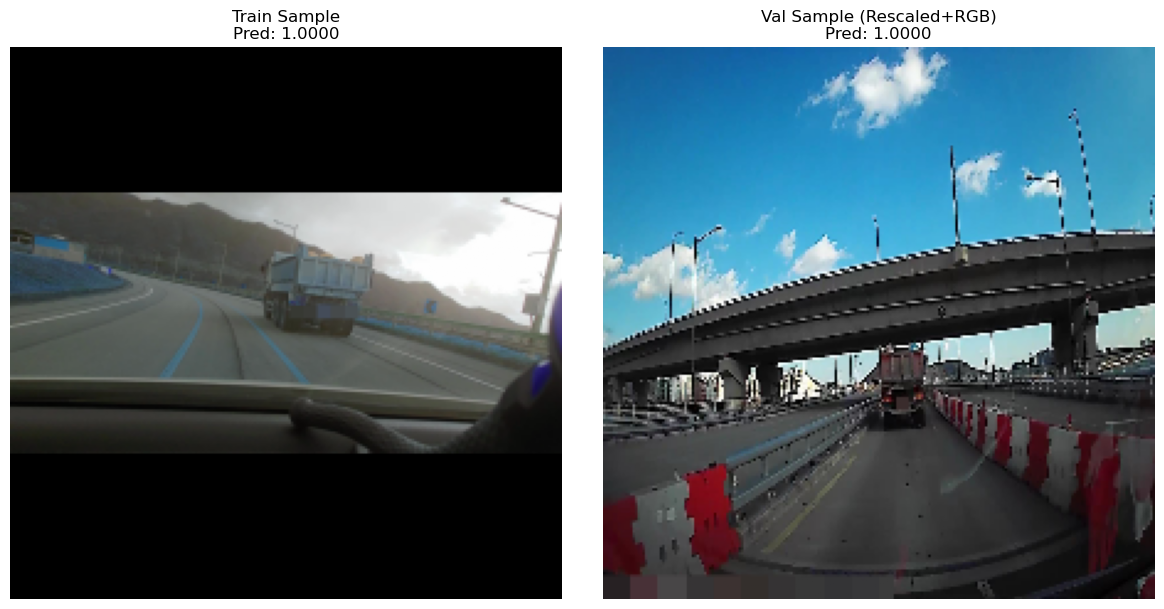

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

# 1. 경로 설정
TRAIN_DIR = "full_npy_images"          
VAL_DIR = r"D:\workspace\clean_val_npy" 
WEIGHTS_PATH = "final_weights_little_manual.h5"

print("🔬 데이터 및 모델 상태 정밀 진단 중...")

# 2. 파일 찾기 (이번엔 진짜 이미지 파일만 찾도록 필터링)
train_files = sorted([f for f in os.listdir(TRAIN_DIR) if f.startswith('img_') and f.endswith('.npy')])
val_files = sorted([f for f in os.listdir(VAL_DIR) if f.startswith('val_img_') and f.endswith('.npy')])

if not train_files or not val_files:
    print("❌ 이미지 파일을 찾을 수 없습니다. 경로를 확인하세요.")
else:
    # 3. 데이터 로드 (Raw Data)
    raw_train = np.load(os.path.join(TRAIN_DIR, train_files[0]))
    raw_val = np.load(os.path.join(VAL_DIR, val_files[0]))

    # 4. 검증 데이터 전처리 시뮬레이션 (우리가 했던 /255 및 색상반전 적용)
    # Val 데이터는 0~255 범위일 것이므로 255로 나누고 RGB 변환
    proc_val = raw_val.astype(np.float32) / 255.0
    proc_val_rgb = proc_val[..., ::-1] # BGR -> RGB 변환

    # 학습 데이터는 이미 0~1이라고 하셨으니 그대로 둠
    proc_train = raw_train 

    # 5. 통계 정보 출력
    print("\n" + "="*60)
    print(f"{'구분':^10} | {'학습 데이터 (Train)':^20} | {'검증 데이터 (Val) - 전처리 후':^20}")
    print("="*60)
    print(f"{'Shape':^10} | {str(proc_train.shape):^20} | {str(proc_val_rgb.shape):^20}")
    print(f"{'Min':^10} | {proc_train.min():^20.4f} | {proc_val_rgb.min():^20.4f}")
    print(f"{'Max':^10} | {proc_train.max():^20.4f} | {proc_val_rgb.max():^20.4f}")
    print(f"{'Mean':^10} | {proc_train.mean():^20.4f} | {proc_val_rgb.mean():^20.4f}")
    
    # 6. 모델 예측 테스트
    def create_model():
        base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = True 
        model = Sequential([
            base_model, GlobalAveragePooling2D(), Dropout(0.3),
            Dense(128, activation='relu'),
            Dense(1, activation='sigmoid', dtype='float32')
        ])
        return model

    model = create_model()
    if os.path.exists(WEIGHTS_PATH):
        model.load_weights(WEIGHTS_PATH)
        
        # 차원 추가 (Batch size 1)
        input_train = np.expand_dims(proc_train, axis=0)
        input_val = np.expand_dims(proc_val_rgb, axis=0)
        
        pred_train = model.predict(input_train, verbose=0)[0][0]
        pred_val = model.predict(input_val, verbose=0)[0][0]
        
        print("-" * 60)
        print(f"{'예측값':^10} | {pred_train:^20.4f} | {pred_val:^20.4f}")
        print(f"({'해설':^10} : 0에 가까우면 정상, 1에 가까우면 불법)")
    else:
        print("❌ 모델 가중치 파일이 없습니다.")

    # 7. 눈으로 확인 (시각화)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(proc_train) # 학습 데이터
    plt.title(f"Train Sample\nPred: {pred_train:.4f}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(proc_val_rgb) # 검증 데이터 (전처리 적용)
    plt.title(f"Val Sample (Rescaled+RGB)\nPred: {pred_val:.4f}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import Sequence
from sklearn.metrics import classification_report, accuracy_score

# ✅ 경로 설정
VAL_DIR = r"D:\workspace\clean_val_npy"
WEIGHTS_PATH = "final_weights_little_manual.h5"

print("✂️ [가설 검증] 센터 크롭(Center Crop) 테스트 시작...")
y_full = np.load(os.path.join(VAL_DIR, "y_val_clean.npy"))
type_full = np.load(os.path.join(VAL_DIR, "type_val_clean.npy"))

target_indices = np.where(type_full == 2)[0]
y_true = y_full[target_indices]

# ✅ 센터 크롭 제너레이터
class CenterCropGenerator(Sequence):
    def __init__(self, val_dir, indices, batch_size=32, crop_ratio=0.6):
        self.val_dir = val_dir
        self.indices = indices
        self.batch_size = batch_size
        self.crop_ratio = crop_ratio # 중앙 60%만 남기고 나머지 버림

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_inds = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X = []
        for i in batch_inds:
            # 1. 로드
            img = np.load(os.path.join(self.val_dir, f"val_img_{i:05d}.npy"))
            
            # 2. 전처리 (BGR 유지 + 스케일링)
            img = img.astype(np.float32) / 255.0
            
            # 3. 🔥 핵심: 센터 크롭 (주변부 잘라내기)
            h, w, _ = img.shape
            ch, cw = int(h * self.crop_ratio), int(w * self.crop_ratio)
            y_start, x_start = (h - ch) // 2, (w - cw) // 2
            
            # 중앙만 잘라서 다시 224x224로 늘림 (Zoom 효과)
            crop_img = img[y_start:y_start+ch, x_start:x_start+cw]
            crop_img = tf.image.resize(crop_img, (224, 224)).numpy()
            
            X.append(crop_img)
        return np.array(X)

# 중앙 60%만 보고 판단하도록 설정
test_gen = CenterCropGenerator(VAL_DIR, target_indices, batch_size=32, crop_ratio=0.6)

# 모델 로드
def create_model():
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True 
    model = Sequential([
        base_model, GlobalAveragePooling2D(), Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid', dtype='float32')
    ])
    return model

model = create_model()

if os.path.exists(WEIGHTS_PATH):
    model.load_weights(WEIGHTS_PATH)
    print("🔥 중앙 집중형(Center Crop) 평가 중...")
    
    y_pred_prob = model.predict(test_gen, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # 길이 보정
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    print("\n" + "="*50)
    print(f"🏆 주변 노이즈 제거(Center Crop) 결과")
    print("="*50)
    print(f"🎯 정확도: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, digits=4))

✂️ [가설 검증] 센터 크롭(Center Crop) 테스트 시작...
🔥 중앙 집중형(Center Crop) 평가 중...
584/584 [==============================] - 55s 93ms/step

🏆 주변 노이즈 제거(Center Crop) 결과
🎯 정확도: 0.5590
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      8229
           1     0.5590    1.0000    0.7171     10430

    accuracy                         0.5590     18659
   macro avg     0.2795    0.5000    0.3586     18659
weighted avg     0.3125    0.5590    0.4008     18659



C:\Users\abc99\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abc99\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abc99\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


⚖️ 가중치 로드 중: final_weights_little_manual.h5
🔥 Grad-CAM 생성 중... (모델이 어디를 보는지 확인하세요)


C:\Users\abc99\AppData\Local\Temp\ipykernel_4852\2067153398.py:95: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


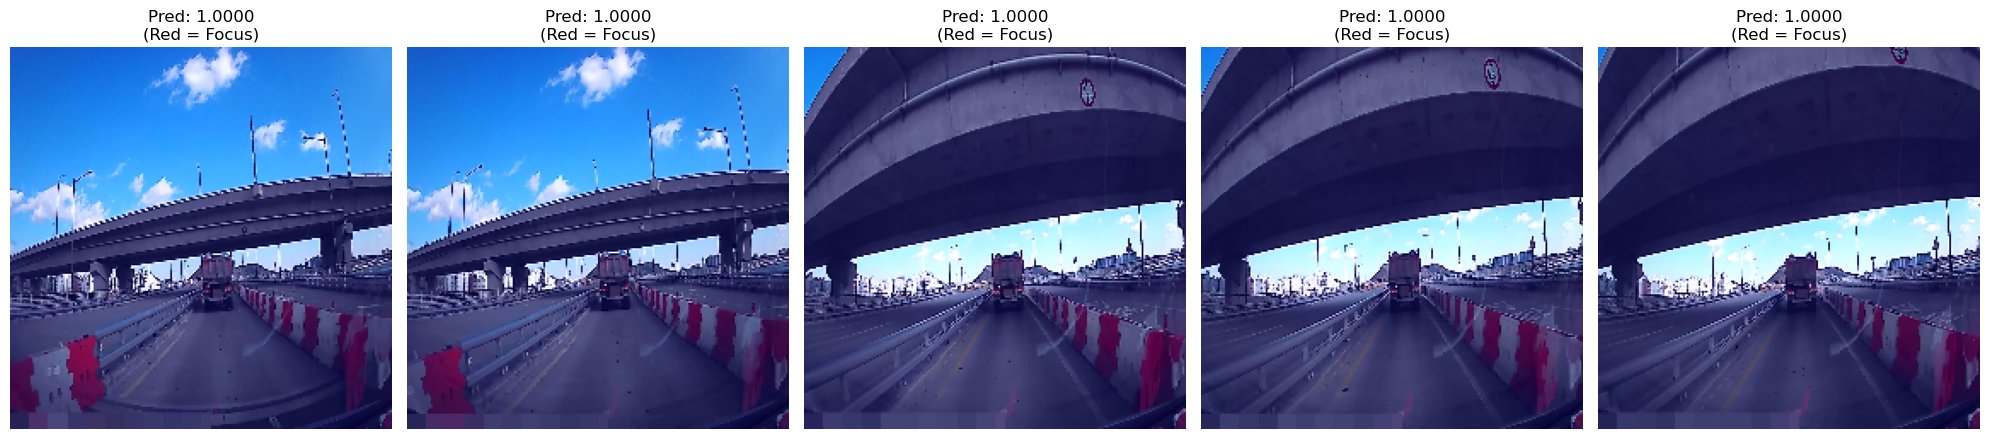

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

# ✅ 경로 설정 (사용자 환경)
VAL_DIR = r"D:\workspace\clean_val_npy"
WEIGHTS_PATH = "final_weights_little_manual.h5"

# 1. 모델 아키텍처 그대로 복원 (Sequential)
# (저장된 가중치가 이 구조이므로 똑같이 만들어야 함)
def create_sequential_model():
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True 
    
    model = Sequential([
        base_model,                 # layers[0]: EfficientNet (Feature Extractor)
        GlobalAveragePooling2D(),   # layers[1]: Pooling
        Dropout(0.3),               # layers[2]: Dropout
        Dense(128, activation='relu'), # layers[3]: Dense
        Dense(1, activation='sigmoid', dtype='float32') # layers[4]: Output
    ])
    return model

model = create_sequential_model()

# 2. 가중치 로드
if os.path.exists(WEIGHTS_PATH):
    print(f"⚖️ 가중치 로드 중: {WEIGHTS_PATH}")
    model.load_weights(WEIGHTS_PATH)
else:
    print("❌ 가중치 파일이 없습니다.")

# 3. 🔥 [핵심] 수동 Grad-CAM 함수 (Graph Disconnected 에러 회피)
def make_gradcam_heatmap(img_array, model):
    with tf.GradientTape() as tape:
        # (1) EfficientNet 부분 통과 (여기서 Feature Map이 나옵니다)
        # EfficientNetB0(include_top=False)의 출력은 7x7x1280 크기의 Feature Map입니다.
        last_conv_layer_output = model.layers[0](img_array)
        
        # (2) Gradient 계산을 위해 Tape에 기록
        tape.watch(last_conv_layer_output)
        
        # (3) 나머지 분류기(Classifier) 부분 통과
        x = model.layers[1](last_conv_layer_output) # GAP
        x = model.layers[2](x)                      # Dropout
        x = model.layers[3](x)                      # Dense 1
        preds = model.layers[4](x)                  # Final Output
        
        # 타겟 클래스 (불법=1 쪽 노드)
        class_channel = preds[:, 0]

    # (4) 미분 계산 (Output에 대한 Feature Map의 변화량)
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # (5) 채널별 중요도(가중치) 계산 (Global Average Pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # (6) 가중치를 곱해서 히트맵 생성
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # (7) ReLU 적용 및 정규화
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds[0][0]

# 4. 이미지 5장 뽑아서 확인
# (차량이 여러 대 있는 복잡한 사진 위주로 확인해보세요)
val_files = sorted([f for f in os.listdir(VAL_DIR) if f.startswith('val_img_')])[:5]

plt.figure(figsize=(20, 8))

print("🔥 Grad-CAM 생성 중... (모델이 어디를 보는지 확인하세요)")

for i, fname in enumerate(val_files):
    # 이미지 로드
    img_path = os.path.join(VAL_DIR, fname)
    img = np.load(img_path)
    original_img = img.astype(np.uint8) 
    
    # 전처리 (BGR 그대로 + 스케일링 1/255)
    input_img = img.astype(np.float32) / 255.0
    input_img = np.expand_dims(input_img, axis=0)
    
    # 히트맵 생성
    heatmap, pred_score = make_gradcam_heatmap(input_img, model)
    
    # 히트맵 시각화
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 원본 + 히트맵 합성 (BGR -> RGB 변환해서 출력)
    superimposed_img = heatmap * 0.4 + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    superimposed_img = superimposed_img[..., ::-1] # 보기 좋게 RGB로 변환
    
    plt.subplot(1, 5, i+1)
    plt.imshow(superimposed_img)
    plt.title(f"Pred: {pred_score:.4f}\n(Red = Focus)")
    plt.axis('off')

plt.tight_layout()
plt.show()